In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import confusion_matrix

import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)


def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [2]:
df = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/1.0.2-data_metabric_table.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT_ID                           2509 non-null   object 
 1   LYMPH_NODES_EXAMINED_POSITIVE        2243 non-null   float64
 2   NPI                                  2287 non-null   float64
 3   COHORT                               2509 non-null   object 
 4   SEX                                  2509 non-null   object 
 5   INTCLUST                             2509 non-null   object 
 6   AGE_AT_DIAGNOSIS                     2498 non-null   float64
 7   OS_MONTHS                            1981 non-null   float64
 8   OS_STATUS                            2509 non-null   bool   
 9   CLAUDIN_SUBTYPE                      2509 non-null   object 
 10  THREEGENE                            2509 non-null   object 
 11  VITAL_STATUS                  

In [3]:
df.head()

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,COHORT,SEX,INTCLUST,AGE_AT_DIAGNOSIS,OS_MONTHS,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,RFS_STATUS,RFS_MONTHS,CELLULARITY_converted,ER_IHC_converted,HER2_SNP6_converted,INFERRED_MENOPAUSAL_STATE_converted,CHEMOTHERAPY_converted,HORMONE_THERAPY_converted,RADIO_THERAPY_converted,PATIENT_ID,SAMPLE_ID,CANCER_TYPE,CANCER_TYPE_DETAILED,GRADE,ONCOTREE_CODE,SAMPLE_TYPE,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,ER_STATUS_converted,HER2_STATUS_converted,PR_STATUS_converted
0,MB-0000,10.0,6.044,1.0,Female,4ER+,75.65,140.500000,False,claudin-low,ER-/HER2-,Living,Right,Ductal/NST,MASTECTOMY,False,138.65,NaN,1.0,2.0,1.0,False,True,True,MB-0000,MB-0000,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,22.0,2.0,0.000000,1.0,-1.0,-1.0
1,MB-0002,0.0,4.020,1.0,Female,4ER+,43.19,84.633333,False,LumA,ER+/HER2- High Prolif,Living,Right,Ductal/NST,BREAST CONSERVING,False,83.52,3.0,1.0,2.0,-1.0,False,True,True,MB-0002,MB-0002,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,10.0,1.0,2.615035,1.0,-1.0,1.0
2,MB-0005,1.0,4.030,1.0,Female,3,48.87,163.700000,True,LumB,nan,Died of Disease,Right,Ductal/NST,MASTECTOMY,True,151.28,3.0,1.0,2.0,-1.0,True,True,False,MB-0005,MB-0005,Breast Cancer,Breast Invasive Ductal Carcinoma,2.0,IDC,Primary,15.0,2.0,2.615035,1.0,-1.0,1.0
3,MB-0006,3.0,4.050,1.0,Female,9,47.68,164.933333,False,LumB,nan,Living,Right,Mixed,MASTECTOMY,False,162.76,2.0,1.0,2.0,-1.0,True,True,True,MB-0006,MB-0006,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,2.0,MDLC,Primary,25.0,2.0,1.307518,1.0,-1.0,1.0
4,MB-0008,8.0,6.080,1.0,Female,9,76.97,41.366667,True,LumB,ER+/HER2- High Prolif,Died of Disease,Right,Mixed,MASTECTOMY,True,18.55,3.0,1.0,2.0,1.0,True,True,True,MB-0008,MB-0008,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,3.0,MDLC,Primary,40.0,2.0,2.615035,1.0,-1.0,1.0


In [4]:
target_columns = [
    # patient
    "OS_MONTHS",
    "RFS_MONTHS",
    "OS_STATUS",
    "RFS_STATUS",
    "VITAL_STATUS",
]

int_columns = [
    # patient
    "LYMPH_NODES_EXAMINED_POSITIVE",
    "OS_MONTHS",
    "RFS_MONTHS",
]

float_columns = [
    # patient
    "NPI",
    "AGE_AT_DIAGNOSIS",
    # sample
    "TUMOR_SIZE",
    "TMB_NONSYNONYMOUS",
]

str_columns = []

# 質的変数（順序尺度）
qualitative_ordinal_columns = [
    # patient
    "CELLULARITY_converted",
    "ER_IHC_converted",
    "HER2_SNP6_converted",
    "INFERRED_MENOPAUSAL_STATE_converted",
    # sample
    "ER_STATUS_converted",
    "HER2_STATUS_converted",
    "GRADE",
    "PR_STATUS_converted",
    "TUMOR_STAGE",
]
# 質的変数（名義尺度）
qualitative_name_columns = [
    # patient
    "COHORT",
    "INTCLUST",
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
    "HISTOLOGICAL_SUBTYPE",
    "BREAST_SURGERY",
    "LATERALITY",
    "VITAL_STATUS",
    # sample
    "CANCER_TYPE",
    "CANCER_TYPE_DETAILED",
    "ONCOTREE_CODE",
]

bool_columns = [
    # patient
    "CHEMOTHERAPY_converted",
    "HORMONE_THERAPY_converted",
    "RADIO_THERAPY_converted",
]

meanless_columns = [
    # patient
    "PATIENT_ID",
    "SEX",
    "OS_STATUS",
    "RFS_STATUS",
    # sample
    "PATIENT_ID",
    "SAMPLE_ID",
    "SAMPLE_TYPE",
]

print(
    df.shape[1],
    len(int_columns)
    + len(float_columns)
    + len(ｓｔｒ_columns)
    + len(qualitative_ordinal_columns)
    + len(qualitative_name_columns)
    + len(bool_columns)
    + len(meanless_columns),
)
assert df.shape[1] == len(int_columns) + len(float_columns) + len(ｓｔｒ_columns) + len(
    qualitative_ordinal_columns
) + len(qualitative_name_columns) + len(bool_columns) + len(
    meanless_columns
), "lack or too much columns"

37 37


### drop na data

null値のデータは機械学習モデルに入力することができない（columnの型がobject形式になり、floatやintしか入力を受け付けないモデルがエラーを吐く）ので、
ここではnull値を全て削除する。  
しかし削除する量が非常に多いので、基本的には補完が推奨される

In [5]:
# df.dropna(how='any', inplace=True)
# for i in qualitative_name_columns:
#    df=df[df[i]!='nan'].copy()
#    df[i].value_counts()
# df.info()

# Ctrl+/→#

In [6]:
df[df.isnull().any(axis=1)]

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,COHORT,SEX,INTCLUST,AGE_AT_DIAGNOSIS,OS_MONTHS,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,RFS_STATUS,RFS_MONTHS,CELLULARITY_converted,ER_IHC_converted,HER2_SNP6_converted,INFERRED_MENOPAUSAL_STATE_converted,CHEMOTHERAPY_converted,HORMONE_THERAPY_converted,RADIO_THERAPY_converted,PATIENT_ID,SAMPLE_ID,CANCER_TYPE,CANCER_TYPE_DETAILED,GRADE,ONCOTREE_CODE,SAMPLE_TYPE,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,ER_STATUS_converted,HER2_STATUS_converted,PR_STATUS_converted
0,MB-0000,10.0,6.044,1.0,Female,4ER+,75.65,140.5,False,claudin-low,ER-/HER2-,Living,Right,Ductal/NST,MASTECTOMY,False,138.65,NaN,1.0,2.0,1.0,False,True,True,MB-0000,MB-0000,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,22.0,2.0,0.000000,1.0,-1.0,-1.0
7,MB-0020,NaN,6.130,1.0,Female,4ER-,70.00,22.4,True,Normal,ER-/HER2-,Died of Disease,Left,Lobular,MASTECTOMY,True,11.74,3.0,-1.0,2.0,1.0,True,False,True,MB-0020,MB-0020,Breast Cancer,Breast Invasive Lobular Carcinoma,3.0,ILC,Primary,65.0,3.0,0.000000,-1.0,-1.0,-1.0
9,MB-0025,11.0,6.680,1.0,Female,nan,76.24,NaN,True,nan,nan,nan,nan,Ductal/NST,nan,True,126.32,NaN,1.0,NaN,NaN,True,True,True,MB-0025,MB-0025,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,34.0,2.0,6.537589,1.0,NaN,NaN
21,MB-0059,NaN,4.034,1.0,Female,8,75.58,160.9,False,LumA,ER+/HER2- High Prolif,Living,Left,Ductal/NST,MASTECTOMY,False,158.78,3.0,1.0,2.0,1.0,False,True,True,MB-0059,MB-0059,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,17.0,1.0,0.000000,1.0,-1.0,1.0
27,MB-0071,NaN,4.100,1.0,Female,8,68.42,131.0,True,LumB,nan,Died of Other Causes,nan,nan,MASTECTOMY,False,129.28,3.0,1.0,2.0,1.0,False,True,True,MB-0071,MB-0071,Breast Cancer,Invasive Breast Carcinoma,2.0,BRCA,Primary,50.0,2.0,0.000000,1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2504,MTS-T2428,0.0,2.540,1.0,Female,nan,70.05,NaN,True,nan,nan,nan,nan,nan,nan,True,4.93,NaN,1.0,NaN,NaN,True,True,True,MTS-T2428,MTS-T2428,Breast Cancer,Invasive Breast Carcinoma,1.0,BRCA,Primary,27.0,1.0,2.615035,1.0,NaN,NaN
2505,MTS-T2429,0.0,4.560,1.0,Female,nan,63.60,NaN,True,nan,nan,nan,nan,nan,nan,True,16.18,NaN,1.0,NaN,NaN,True,True,True,MTS-T2429,MTS-T2429,Breast Cancer,Invasive Breast Carcinoma,2.0,BRCA,Primary,28.0,2.0,5.230071,1.0,NaN,NaN
2506,MTS-T2430,0.0,NaN,nan,Female,nan,NaN,NaN,True,nan,nan,nan,nan,nan,nan,True,NaN,NaN,NaN,NaN,NaN,True,True,True,MTS-T2430,MTS-T2430,Breast Cancer,Invasive Breast Carcinoma,NaN,BRCA,Primary,NaN,0.0,7.845106,NaN,NaN,NaN
2507,MTS-T2431,0.0,NaN,nan,Female,nan,NaN,NaN,True,nan,nan,nan,nan,nan,nan,True,NaN,NaN,NaN,NaN,NaN,True,True,True,MTS-T2431,MTS-T2431,Breast Cancer,Invasive Breast Carcinoma,NaN,BRCA,Primary,NaN,0.0,9.152624,NaN,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT_ID                           2509 non-null   object 
 1   LYMPH_NODES_EXAMINED_POSITIVE        2243 non-null   float64
 2   NPI                                  2287 non-null   float64
 3   COHORT                               2509 non-null   object 
 4   SEX                                  2509 non-null   object 
 5   INTCLUST                             2509 non-null   object 
 6   AGE_AT_DIAGNOSIS                     2498 non-null   float64
 7   OS_MONTHS                            1981 non-null   float64
 8   OS_STATUS                            2509 non-null   bool   
 9   CLAUDIN_SUBTYPE                      2509 non-null   object 
 10  THREEGENE                            2509 non-null   object 
 11  VITAL_STATUS                  

In [8]:
df["OS_MONTHS"].isnull().sum()

528

### SAMPLE_IDがMBのデータのみを取得
(MTSはデータ不足が多いため)


In [9]:
df["SAMPLE_ID"]

0         MB-0000
1         MB-0002
2         MB-0005
3         MB-0006
4         MB-0008
          ...    
2504    MTS-T2428
2505    MTS-T2429
2506    MTS-T2430
2507    MTS-T2431
2508    MTS-T2432
Name: SAMPLE_ID, Length: 2509, dtype: object

In [10]:
df_MB = df[df["SAMPLE_ID"].str.contains("MB")]
df_MB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1985 entries, 0 to 1984
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT_ID                           1985 non-null   object 
 1   LYMPH_NODES_EXAMINED_POSITIVE        1909 non-null   float64
 2   NPI                                  1984 non-null   float64
 3   COHORT                               1985 non-null   object 
 4   SEX                                  1985 non-null   object 
 5   INTCLUST                             1985 non-null   object 
 6   AGE_AT_DIAGNOSIS                     1985 non-null   float64
 7   OS_MONTHS                            1981 non-null   float64
 8   OS_STATUS                            1985 non-null   bool   
 9   CLAUDIN_SUBTYPE                      1985 non-null   object 
 10  THREEGENE                            1985 non-null   object 
 11  VITAL_STATUS                  

In [11]:
df_MB

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,COHORT,SEX,INTCLUST,AGE_AT_DIAGNOSIS,OS_MONTHS,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,RFS_STATUS,RFS_MONTHS,CELLULARITY_converted,ER_IHC_converted,HER2_SNP6_converted,INFERRED_MENOPAUSAL_STATE_converted,CHEMOTHERAPY_converted,HORMONE_THERAPY_converted,RADIO_THERAPY_converted,PATIENT_ID,SAMPLE_ID,CANCER_TYPE,CANCER_TYPE_DETAILED,GRADE,ONCOTREE_CODE,SAMPLE_TYPE,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,ER_STATUS_converted,HER2_STATUS_converted,PR_STATUS_converted
0,MB-0000,10.0,6.044,1.0,Female,4ER+,75.65,140.500000,False,claudin-low,ER-/HER2-,Living,Right,Ductal/NST,MASTECTOMY,False,138.65,NaN,1.0,2.0,1.0,False,True,True,MB-0000,MB-0000,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,22.0,2.0,0.000000,1.0,-1.0,-1.0
1,MB-0002,0.0,4.020,1.0,Female,4ER+,43.19,84.633333,False,LumA,ER+/HER2- High Prolif,Living,Right,Ductal/NST,BREAST CONSERVING,False,83.52,3.0,1.0,2.0,-1.0,False,True,True,MB-0002,MB-0002,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,10.0,1.0,2.615035,1.0,-1.0,1.0
2,MB-0005,1.0,4.030,1.0,Female,3,48.87,163.700000,True,LumB,nan,Died of Disease,Right,Ductal/NST,MASTECTOMY,True,151.28,3.0,1.0,2.0,-1.0,True,True,False,MB-0005,MB-0005,Breast Cancer,Breast Invasive Ductal Carcinoma,2.0,IDC,Primary,15.0,2.0,2.615035,1.0,-1.0,1.0
3,MB-0006,3.0,4.050,1.0,Female,9,47.68,164.933333,False,LumB,nan,Living,Right,Mixed,MASTECTOMY,False,162.76,2.0,1.0,2.0,-1.0,True,True,True,MB-0006,MB-0006,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,2.0,MDLC,Primary,25.0,2.0,1.307518,1.0,-1.0,1.0
4,MB-0008,8.0,6.080,1.0,Female,9,76.97,41.366667,True,LumB,ER+/HER2- High Prolif,Died of Disease,Right,Mixed,MASTECTOMY,True,18.55,3.0,1.0,2.0,1.0,True,True,True,MB-0008,MB-0008,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,3.0,MDLC,Primary,40.0,2.0,2.615035,1.0,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,MB-7295,1.0,5.050,4.0,Female,3,43.10,196.866667,False,LumA,ER+/HER2- Low Prolif,Living,Right,Lobular,BREAST CONSERVING,False,194.28,3.0,1.0,2.0,-1.0,False,True,True,MB-7295,MB-7295,Breast Cancer,Breast Invasive Lobular Carcinoma,3.0,ILC,Primary,25.0,NaN,5.230071,1.0,-1.0,1.0
1981,MB-7296,1.0,5.040,4.0,Female,5,42.88,44.733333,True,LumB,nan,Died of Disease,nan,Ductal/NST,MASTECTOMY,True,16.09,3.0,1.0,3.0,-1.0,False,False,True,MB-7296,MB-7296,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,20.0,NaN,7.845106,1.0,1.0,-1.0
1982,MB-7297,45.0,6.050,4.0,Female,1,62.90,175.966667,True,LumB,nan,Died of Disease,Left,Ductal/NST,MASTECTOMY,True,121.18,3.0,1.0,2.0,1.0,False,True,True,MB-7297,MB-7297,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,25.0,NaN,5.230071,1.0,-1.0,1.0
1983,MB-7298,12.0,5.050,4.0,Female,1,61.16,86.233333,True,LumB,ER+/HER2- High Prolif,Died of Other Causes,nan,Ductal/NST,MASTECTOMY,False,85.10,2.0,1.0,2.0,1.0,False,True,False,MB-7298,MB-7298,Breast Cancer,Breast Invasive Ductal Carcinoma,2.0,IDC,Primary,25.0,NaN,19.612766,1.0,-1.0,1.0


### OS_MONTHSを除く列を所得

In [12]:
df_MB2 = df_MB[df_MB.columns.difference(["OS_MONTHS"])]
df_MB2.head()

,AGE_AT_DIAGNOSIS,BREAST_SURGERY,CANCER_TYPE,CANCER_TYPE_DETAILED,CELLULARITY_converted,CHEMOTHERAPY_converted,CLAUDIN_SUBTYPE,COHORT,ER_IHC_converted,ER_STATUS_converted,GRADE,HER2_SNP6_converted,HER2_STATUS_converted,HISTOLOGICAL_SUBTYPE,HORMONE_THERAPY_converted,INFERRED_MENOPAUSAL_STATE_converted,INTCLUST,LATERALITY,LYMPH_NODES_EXAMINED_POSITIVE,NPI,ONCOTREE_CODE,OS_STATUS,PATIENT_ID,PATIENT_ID,PR_STATUS_converted,RADIO_THERAPY_converted,RFS_MONTHS,RFS_STATUS,SAMPLE_ID,SAMPLE_TYPE,SEX,THREEGENE,TMB_NONSYNONYMOUS,TUMOR_SIZE,TUMOR_STAGE,VITAL_STATUS
0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,False,claudin-low,1.0,1.0,1.0,3.0,2.0,-1.0,Ductal/NST,True,1.0,4ER+,Right,10.0,6.044,IDC,False,MB-0000,MB-0000,-1.0,True,138.65,False,MB-0000,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,False,LumA,1.0,1.0,1.0,3.0,2.0,-1.0,Ductal/NST,True,-1.0,4ER+,Right,0.0,4.020,IDC,False,MB-0002,MB-0002,1.0,True,83.52,False,MB-0002,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,True,LumB,1.0,1.0,1.0,2.0,2.0,-1.0,Ductal/NST,True,-1.0,3,Right,1.0,4.030,IDC,True,MB-0005,MB-0005,1.0,False,151.28,True,MB-0005,Primary,Female,nan,2.615035,15.0,2.0,Died of Disease
3,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,2.0,True,LumB,1.0,1.0,1.0,2.0,2.0,-1.0,Mixed,True,-1.0,9,Right,3.0,4.050,MDLC,False,MB-0006,MB-0006,1.0,True,162.76,False,MB-0006,Primary,Female,nan,1.307518,25.0,2.0,Living
4,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,3.0,True,LumB,1.0,1.0,1.0,3.0,2.0,-1.0,Mixed,True,1.0,9,Right,8.0,6.080,MDLC,True,MB-0008,MB-0008,1.0,True,18.55,True,MB-0008,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


## OS_MONTHSを除く列の欠損値補完

In [13]:
df_MB2.fillna(df_MB2.mean(), inplace=True)

C:\Users\uga\AppData\Local\Temp\ipykernel_23692\4116373803.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_MB2.fillna(df_MB2.mean(),inplace=True)
C:\Users\uga\AppData\Local\Temp\ipykernel_23692\4116373803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MB2.fillna(df_MB2.mean(),inplace=True)
C:\Users\uga\AppData\Local\Temp\ipykernel_23692\4116373803.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## 欠損値補完したMB_2とOS_MONTHSを結合

In [14]:
s = df_MB["OS_MONTHS"]
df_MB3 = pd.concat([df_MB2, s], axis=1)

## OS_MONTHSの欠損値も埋めてないことを確認

In [15]:
df_MB3[df_MB3.isnull().any(axis=1)]

,AGE_AT_DIAGNOSIS,BREAST_SURGERY,CANCER_TYPE,CANCER_TYPE_DETAILED,CELLULARITY_converted,CHEMOTHERAPY_converted,CLAUDIN_SUBTYPE,COHORT,ER_IHC_converted,ER_STATUS_converted,GRADE,HER2_SNP6_converted,HER2_STATUS_converted,HISTOLOGICAL_SUBTYPE,HORMONE_THERAPY_converted,INFERRED_MENOPAUSAL_STATE_converted,INTCLUST,LATERALITY,LYMPH_NODES_EXAMINED_POSITIVE,NPI,ONCOTREE_CODE,OS_STATUS,PATIENT_ID,PATIENT_ID,PR_STATUS_converted,RADIO_THERAPY_converted,RFS_MONTHS,RFS_STATUS,SAMPLE_ID,SAMPLE_TYPE,SEX,THREEGENE,TMB_NONSYNONYMOUS,TUMOR_SIZE,TUMOR_STAGE,VITAL_STATUS,OS_MONTHS
9,76.24,nan,Breast Cancer,Breast Invasive Ductal Carcinoma,2.391236,True,nan,1.0,1.0,1.0,3.0,2.165152,-0.750505,Ductal/NST,True,0.571717,nan,nan,11.0,6.68,IDC,True,MB-0025,MB-0025,0.050505,True,126.32,True,MB-0025,Primary,Female,nan,6.537589,34.0,2.0,nan,NaN
223,51.45,nan,Breast Cancer,Invasive Breast Carcinoma,2.391236,True,nan,1.0,1.0,1.0,2.0,2.165152,-0.750505,nan,True,0.571717,nan,nan,1.0,4.24,BRCA,True,MB-0326,MB-0326,0.050505,True,191.25,False,MB-0326,Primary,Female,nan,11.767659,12.0,2.0,nan,NaN
226,76.84,nan,Breast Cancer,Breast Invasive Ductal Carcinoma,2.391236,True,nan,1.0,1.0,1.0,3.0,2.165152,-0.750505,Ductal/NST,True,0.571717,nan,nan,3.0,5.06,IDC,True,MB-0329,MB-0329,0.050505,True,25.63,False,MB-0329,Primary,Female,nan,6.537589,30.0,2.0,nan,NaN
411,66.73,nan,Breast Cancer,Invasive Breast Carcinoma,2.391236,True,nan,1.0,1.0,1.0,2.0,2.165152,-0.750505,nan,True,0.571717,nan,nan,0.0,4.48,BRCA,True,MB-0547,MB-0547,0.050505,True,185.46,False,MB-0547,Primary,Female,nan,2.615035,25.0,2.0,nan,NaN


## create target column

目的変数：5年以内の死亡判定→5年以内のデータは除外する

In [16]:
# df['VITAL_STATUS'].value_counts()
df_MB3["VITAL_STATUS"].value_counts()

Living                  837
Died of Disease         646
Died of Other Causes    497
nan                       5
Name: VITAL_STATUS, dtype: int64

In [17]:
# df.shape, df[(df['OS_MONTHS']<=60)].shape, df[(df['OS_MONTHS']>=60)].shape
df_MB3.shape, df_MB3[(df_MB3["OS_MONTHS"] <= 60)].shape, df_MB3[
    (df_MB3["OS_MONTHS"] >= 60)
].shape

((1985, 37), (491, 37), (1490, 37))

In [18]:
# df[(df['OS_MONTHS']<=60) & (df['VITAL_STATUS']=='Died of Disease')].shape
df_MB3[
    (df_MB3["OS_MONTHS"] <= 60) & (df_MB3["VITAL_STATUS"] == "Died of Disease")
].shape

(337, 37)

### 目的変数の生成

VITAL_STATUSとOS_MONTHSから目的変数を生成する

In [19]:
df_enough_months = df_MB3.copy()

df_enough_months["IN_5YEARS_STATUS"] = np.nan
# dead in 5years=True
df_enough_months["IN_5YEARS_STATUS"] = df_enough_months["IN_5YEARS_STATUS"].mask(
    (df_enough_months["OS_MONTHS"] <= 60)
    & (df_enough_months["VITAL_STATUS"] == "Died of Disease"),
    True,
)
df_enough_months["IN_5YEARS_STATUS"] = df_enough_months["IN_5YEARS_STATUS"].mask(
    (df_enough_months["OS_MONTHS"] >= 60), False
)
df_enough_months.dropna(inplace=True)
df_enough_months.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 0 to 1984
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   AGE_AT_DIAGNOSIS                     1827 non-null   float64
 1   BREAST_SURGERY                       1827 non-null   object 
 2   CANCER_TYPE                          1827 non-null   object 
 3   CANCER_TYPE_DETAILED                 1827 non-null   object 
 4   CELLULARITY_converted                1827 non-null   float64
 5   CHEMOTHERAPY_converted               1827 non-null   bool   
 6   CLAUDIN_SUBTYPE                      1827 non-null   object 
 7   COHORT                               1827 non-null   object 
 8   ER_IHC_converted                     1827 non-null   float64
 9   ER_STATUS_converted                  1827 non-null   float64
 10  GRADE                                1827 non-null   float64
 11  HER2_SNP6_converted           

In [20]:
df_enough_months["IN_5YEARS_STATUS"].value_counts()

False    1490
True      337
Name: IN_5YEARS_STATUS, dtype: int64

In [21]:
df_enough_months.isnull().sum().sum()

0

In [22]:
df_enough_months["IN_5YEARS_STATUS"] = df_enough_months["IN_5YEARS_STATUS"].astype(bool)
df_enough_months.dtypes

AGE_AT_DIAGNOSIS                       float64
BREAST_SURGERY                          object
CANCER_TYPE                             object
CANCER_TYPE_DETAILED                    object
CELLULARITY_converted                  float64
CHEMOTHERAPY_converted                    bool
CLAUDIN_SUBTYPE                         object
COHORT                                  object
ER_IHC_converted                       float64
ER_STATUS_converted                    float64
GRADE                                  float64
HER2_SNP6_converted                    float64
HER2_STATUS_converted                  float64
HISTOLOGICAL_SUBTYPE                    object
HORMONE_THERAPY_converted                 bool
INFERRED_MENOPAUSAL_STATE_converted    float64
INTCLUST                                object
LATERALITY                              object
LYMPH_NODES_EXAMINED_POSITIVE          float64
NPI                                    float64
ONCOTREE_CODE                           object
OS_STATUS    

### drop columns
targetを作成したので、リークになりうるcolumnsは削除 

In [23]:
def create_drop_columne(
    target: str,
    target_columns: list = target_columns,
    meanless_columns: list = meanless_columns,
):
    drop_columns = [i for i in target_columns if i not in [target]] + meanless_columns
    return drop_columns

In [24]:
target = "IN_5YEARS_STATUS"
drop_columns = create_drop_columne(target)
df_droped = df_enough_months.drop(drop_columns, axis=1).copy()
df_enough_months.shape, df_droped.shape

((1827, 38), (1827, 28))

In [25]:
df_droped.columns

Index(['AGE_AT_DIAGNOSIS', 'BREAST_SURGERY', 'CANCER_TYPE',
       'CANCER_TYPE_DETAILED', 'CELLULARITY_converted',
       'CHEMOTHERAPY_converted', 'CLAUDIN_SUBTYPE', 'COHORT',
       'ER_IHC_converted', 'ER_STATUS_converted', 'GRADE',
       'HER2_SNP6_converted', 'HER2_STATUS_converted', 'HISTOLOGICAL_SUBTYPE',
       'HORMONE_THERAPY_converted', 'INFERRED_MENOPAUSAL_STATE_converted',
       'INTCLUST', 'LATERALITY', 'LYMPH_NODES_EXAMINED_POSITIVE', 'NPI',
       'ONCOTREE_CODE', 'PR_STATUS_converted', 'RADIO_THERAPY_converted',
       'THREEGENE', 'TMB_NONSYNONYMOUS', 'TUMOR_SIZE', 'TUMOR_STAGE',
       'IN_5YEARS_STATUS'],
      dtype='object')

### onehot encoding
決定木に入れるためにobject型をonehotエンコーディング(nullは削除する)

In [26]:
qualitative_name_columns.remove(
    "VITAL_STATUS"
) if "VITAL_STATUS" in qualitative_name_columns else qualitative_name_columns
qualitative_name_columns

['COHORT',
 'INTCLUST',
 'CLAUDIN_SUBTYPE',
 'THREEGENE',
 'HISTOLOGICAL_SUBTYPE',
 'BREAST_SURGERY',
 'LATERALITY',
 'CANCER_TYPE',
 'CANCER_TYPE_DETAILED',
 'ONCOTREE_CODE']

In [27]:
onehot_encoder = OneHotEncoder()
onehot_encoding_columns = qualitative_name_columns
onehot_encoder.fit(df_droped[onehot_encoding_columns])
display(onehot_encoder.categories_)
display(onehot_encoder.get_feature_names_out(onehot_encoding_columns))
# enc.transform(df[encoding_columns]).toarray()
df_onehot = pd.DataFrame(
    onehot_encoder.transform(df_droped[onehot_encoding_columns]).toarray(),
    columns=onehot_encoder.get_feature_names_out(onehot_encoding_columns),
)

[array(['1.0', '2.0', '3.0', '4.0', '5.0'], dtype=object),
 array(['1', '10', '2', '3', '4ER+', '4ER-', '5', '6', '7', '8', '9',
        'nan'], dtype=object),
 array(['Basal', 'Her2', 'LumA', 'LumB', 'NC', 'Normal', 'claudin-low',
        'nan'], dtype=object),
 array(['ER+/HER2- High Prolif', 'ER+/HER2- Low Prolif', 'ER-/HER2-',
        'HER2+', 'nan'], dtype=object),
 array(['Ductal/NST', 'Lobular', 'Medullary', 'Metaplastic', 'Mixed',
        'Mucinous', 'Other', 'Tubular/ cribriform', 'nan'], dtype=object),
 array(['BREAST CONSERVING', 'MASTECTOMY', 'nan'], dtype=object),
 array(['Left', 'Right', 'nan'], dtype=object),
 array(['Breast Cancer', 'Breast Sarcoma'], dtype=object),
 array(['Breast', 'Breast Angiosarcoma',
        'Breast Invasive Ductal Carcinoma',
        'Breast Invasive Lobular Carcinoma',
        'Breast Invasive Mixed Mucinous Carcinoma',
        'Breast Mixed Ductal and Lobular Carcinoma',
        'Invasive Breast Carcinoma', 'Metaplastic Breast Cancer'],
       

array(['COHORT_1.0', 'COHORT_2.0', 'COHORT_3.0', 'COHORT_4.0',
       'COHORT_5.0', 'INTCLUST_1', 'INTCLUST_10', 'INTCLUST_2',
       'INTCLUST_3', 'INTCLUST_4ER+', 'INTCLUST_4ER-', 'INTCLUST_5',
       'INTCLUST_6', 'INTCLUST_7', 'INTCLUST_8', 'INTCLUST_9',
       'INTCLUST_nan', 'CLAUDIN_SUBTYPE_Basal', 'CLAUDIN_SUBTYPE_Her2',
       'CLAUDIN_SUBTYPE_LumA', 'CLAUDIN_SUBTYPE_LumB',
       'CLAUDIN_SUBTYPE_NC', 'CLAUDIN_SUBTYPE_Normal',
       'CLAUDIN_SUBTYPE_claudin-low', 'CLAUDIN_SUBTYPE_nan',
       'THREEGENE_ER+/HER2- High Prolif',
       'THREEGENE_ER+/HER2- Low Prolif', 'THREEGENE_ER-/HER2-',
       'THREEGENE_HER2+', 'THREEGENE_nan',
       'HISTOLOGICAL_SUBTYPE_Ductal/NST', 'HISTOLOGICAL_SUBTYPE_Lobular',
       'HISTOLOGICAL_SUBTYPE_Medullary',
       'HISTOLOGICAL_SUBTYPE_Metaplastic', 'HISTOLOGICAL_SUBTYPE_Mixed',
       'HISTOLOGICAL_SUBTYPE_Mucinous', 'HISTOLOGICAL_SUBTYPE_Other',
       'HISTOLOGICAL_SUBTYPE_Tubular/ cribriform',
       'HISTOLOGICAL_SUBTYPE_nan', 'BREA

In [28]:
df_onehot.shape

(1827, 63)

In [29]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 63 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   COHORT_1.0                                                      1827 non-null   float64
 1   COHORT_2.0                                                      1827 non-null   float64
 2   COHORT_3.0                                                      1827 non-null   float64
 3   COHORT_4.0                                                      1827 non-null   float64
 4   COHORT_5.0                                                      1827 non-null   float64
 5   INTCLUST_1                                                      1827 non-null   float64
 6   INTCLUST_10                                                     1827 non-null   float64
 7   INTCLUST_2                                         

In [30]:
df_encoded = pd.merge(
    df_droped.reset_index(drop=True),
    df_onehot.reset_index(drop=True),
    left_index=True,
    right_index=True,
).drop(onehot_encoding_columns, axis=1)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 81 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   AGE_AT_DIAGNOSIS                                                1827 non-null   float64
 1   CELLULARITY_converted                                           1827 non-null   float64
 2   CHEMOTHERAPY_converted                                          1827 non-null   bool   
 3   ER_IHC_converted                                                1827 non-null   float64
 4   ER_STATUS_converted                                             1827 non-null   float64
 5   GRADE                                                           1827 non-null   float64
 6   HER2_SNP6_converted                                             1827 non-null   float64
 7   HER2_STATUS_converted                              

In [31]:
df_encoded.isnull().sum().sum()

0

# 学習モデル作成

学習用にデータを分割

In [32]:
df_encoded.isnull().sum().sum()

0

In [33]:
y = df_encoded[target]
X = df_encoded.drop(target, axis=1)

In [34]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1827 entries, 0 to 1826
Series name: IN_5YEARS_STATUS
Non-Null Count  Dtype
--------------  -----
1827 non-null   bool 
dtypes: bool(1)
memory usage: 1.9 KB


In [35]:
y.value_counts()

False    1490
True      337
Name: IN_5YEARS_STATUS, dtype: int64

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 80 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   AGE_AT_DIAGNOSIS                                                1827 non-null   float64
 1   CELLULARITY_converted                                           1827 non-null   float64
 2   CHEMOTHERAPY_converted                                          1827 non-null   bool   
 3   ER_IHC_converted                                                1827 non-null   float64
 4   ER_STATUS_converted                                             1827 non-null   float64
 5   GRADE                                                           1827 non-null   float64
 6   HER2_SNP6_converted                                             1827 non-null   float64
 7   HER2_STATUS_converted                              

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1
)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(1278, 80)

(549, 80)

(1278,)

(549,)

False    1027
True      251
Name: IN_5YEARS_STATUS, dtype: int64

False    463
True      86
Name: IN_5YEARS_STATUS, dtype: int64

In [38]:
accuracies = {}

for nodes in range(2, 50):
    clf = DecisionTreeClassifier(max_leaf_nodes=nodes)
    clf = clf.fit(X_train, y_train)
    # print(clf.classes_)

    y_pred = clf.predict(X_test)
    # accuracy

    accuracy = sum(y_test == y_pred) / y_test.shape[0]
    accuracies[nodes] = accuracy
    print("nodes: ", nodes, "　　accuracy: ", accuracy)

nodes:  2 　　accuracy:  0.843351548269581
nodes:  3 　　accuracy:  0.8342440801457195
nodes:  4 　　accuracy:  0.8469945355191257
nodes:  5 　　accuracy:  0.843351548269581
nodes:  6 　　accuracy:  0.843351548269581
nodes:  7 　　accuracy:  0.843351548269581
nodes:  8 　　accuracy:  0.8451730418943534
nodes:  9 　　accuracy:  0.8451730418943534
nodes:  10 　　accuracy:  0.8415300546448088
nodes:  11 　　accuracy:  0.8415300546448088
nodes:  12 　　accuracy:  0.8415300546448088
nodes:  13 　　accuracy:  0.8415300546448088
nodes:  14 　　accuracy:  0.8415300546448088
nodes:  15 　　accuracy:  0.8360655737704918
nodes:  16 　　accuracy:  0.8360655737704918
nodes:  17 　　accuracy:  0.8360655737704918
nodes:  18 　　accuracy:  0.8360655737704918
nodes:  19 　　accuracy:  0.8360655737704918
nodes:  20 　　accuracy:  0.8451730418943534
nodes:  21 　　accuracy:  0.8451730418943534
nodes:  22 　　accuracy:  0.8451730418943534
nodes:  23 　　accuracy:  0.8451730418943534
nodes:  24 　　accuracy:  0.843351548269581
nodes:  25 　　accuracy:  

In [39]:
max(accuracies, key=accuracies.get)

4

最も精度のよいleaf_nodesのパラメーターで再度モデル構築

In [40]:
clf = DecisionTreeClassifier(max_leaf_nodes=max(accuracies, key=accuracies.get))
clf = clf.fit(X_train, y_train)
# print(clf.classes_)

y_pred = clf.predict(X_test)
# accuracy

print(sum(y_test == y_pred) / y_test.shape[0])

0.8469945355191257


In [41]:
y.unique()

array([False,  True])

In [42]:
dot_data = StringIO()  # dotファイル情報の格納先
export_graphviz(
    clf,
    out_file=dot_data,
    feature_names=X.columns,
    # class_names= y.unique(),
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
graph.write_png(config.TREE_DIR + "/2.0-decision_tree_model.png")

True

In [43]:
y_test.value_counts()[0]

463

In [44]:
display(y_test.value_counts())

display("baseline:", y_test.value_counts() / y_test.size)

False    463
True      86
Name: IN_5YEARS_STATUS, dtype: int64

'baseline:'

False    0.843352
True     0.156648
Name: IN_5YEARS_STATUS, dtype: float64

In [45]:
y_pred = clf.predict(X_test)
# accuracy
sum(y_test == y_pred) / y_test.shape[0]

0.8469945355191257

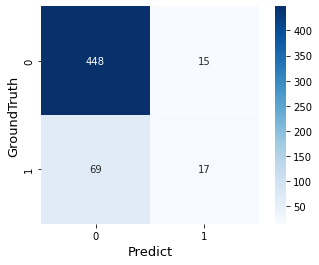

In [46]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap="Blues", fmt="1.0f")
plt.xlabel("Predict", fontsize=13)
plt.ylabel("GroundTruth", fontsize=13)

plt.savefig(config.TREE_DIR + "/2.0-decision_tree_confusion-matrix.png")